In [1]:
#Для построения архитектуры ESN использовалась библиотека reservoirPy, основанная на графовых вычислениях
import numpy as np
import matplotlib.pyplot as plt
from reservoirpy.datasets import to_forecasting # разбиение на train/test
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge #узлы резервуара и считывающего слоя
from reservoirpy.observables import nrmse, rsquare
import json
from scipy.integrate import solve_ivp
import warnings
from nolitsa import data
from reservoirpy.datasets import to_forecasting
import copy

c:\ANACONDA\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def train_test(X_train, y_train, X_test, y_test):
    sample = 2000
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 2000), X_train[-sample:], label="X_train")
    plt.plot(np.arange(0, 2000), y_train[-sample:], label="y_train")
    plt.plot(np.arange(2000, 2000+test_len), X_test, label="X_test")
    plt.plot(np.arange(2000, 2000+test_len), y_test, label="y_test")
    plt.xlabel(r'$t$')
    plt.legend()
    plt.show()
    
def results(y_pred, y_test, sample=1500):
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")
    ax.axvline(x=sample-10, color="red")  # Add vertical line
    ax.legend()
    plt.show()

In [3]:
length = 100000
train_train = 50000

dt = 0.01
x0 = [0.62225717, -0.08232857, 30.60845379]


x = data.lorenz(length=length, sample=dt, x0=x0,
               sigma=16.0, beta=4.0, rho=45.92)[1]

#11
time = copy.deepcopy(x) #берем значения Лоренца
X = time[:,0] #берем только x
X = X.reshape(length,1) #зачем-то 
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1 #нормализация(?)

In [4]:
X

array([[-0.15786183],
       [-0.1784044 ],
       [-0.20207622],
       ...,
       [-0.51225915],
       [-0.48133997],
       [-0.44862266]])

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model-0: 50000it [00:07, 6642.84it/s]?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:07<00:00,  7.58s/it]


Fitting node Ridge-0...


Running Model-0: 49990it [00:08, 5596.31it/s]         


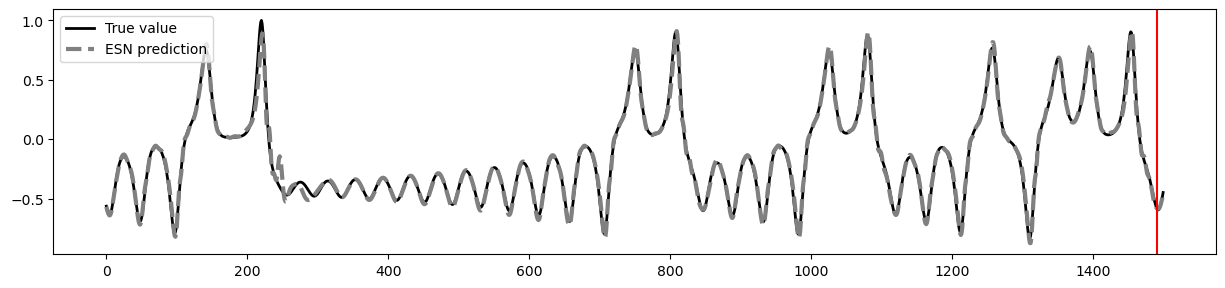

In [5]:
x, y = to_forecasting(X, forecast=10)

X_train1, y_train1 = x[:train_train], y[:train_train]
X_test1, y_test1 = x[train_train:], y[train_train:]

#train_test(X_train1, y_train1, X_test1, y_test1)

#Первый тестовый набор параметров 
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 1234

#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1)
results(y_pred1, y_test1, sample=1500)
###HERE1

In [6]:
def get_traj(n, x0 = [0.62225717, -0.08232857, 30.60845379]):
    
    dt = 0.01
    tm = []
    x00 = x0

    for i in range(n):

        for j in range(len(x0)):
            x00[j] = x0[j] + (-1)**j + 2/(i+1)

        xt = data.lorenz(length=length, sample=dt, x0=x00,
                sigma=16.0, beta=4.0, rho=45.92)[1]

        time = copy.deepcopy(xt) #берем значения Лоренца
        X0 = time[:,0] #берем только x
        X0 = X0.reshape(length,1) #зачем-то 
        X0 = 2 * (X0 - X0.min()) / (X0.max() - X0.min()) - 1 #нормализация

        tm.append(X0)
        
    #X = np.concatenate(tm, axis=1)

    return tm

In [7]:
N = 4
Y = get_traj(N)

In [8]:
Y[0]

array([[-0.27388205],
       [-0.29785126],
       [-0.32410135],
       ...,
       [ 0.18540341],
       [ 0.14827991],
       [ 0.11678177]])

In [9]:
X.shape

(100000, 1)

In [10]:
Y[0].shape

(100000, 1)

Running Model-0: 49990it [00:06, 7159.13it/s]         


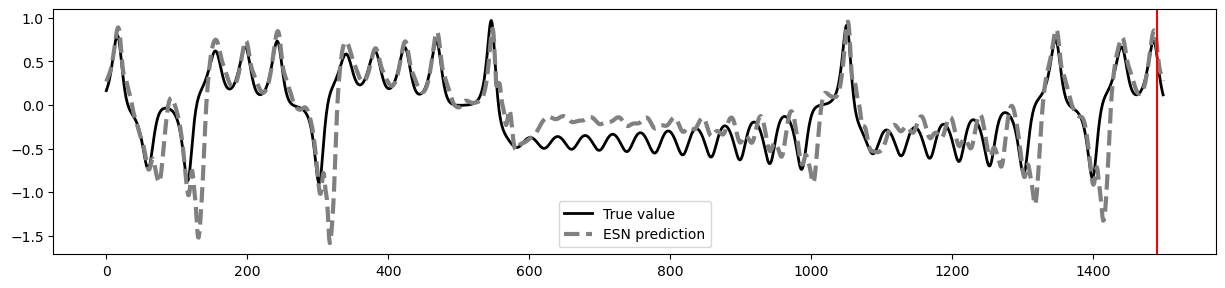

Running Model-0: 49990it [00:06, 7569.41it/s]         


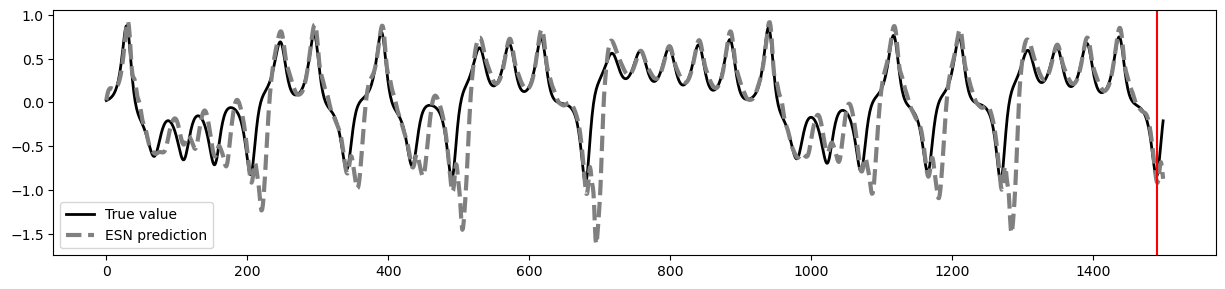

Running Model-0: 49990it [00:06, 7426.59it/s]         


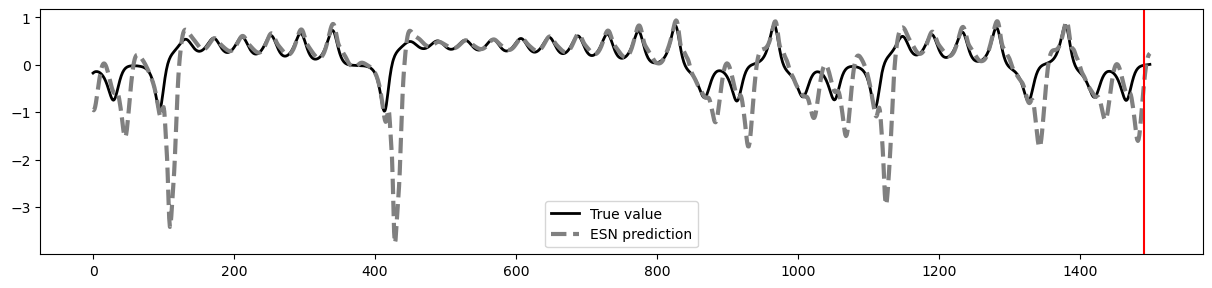

Running Model-0: 49990it [00:06, 7565.89it/s]         


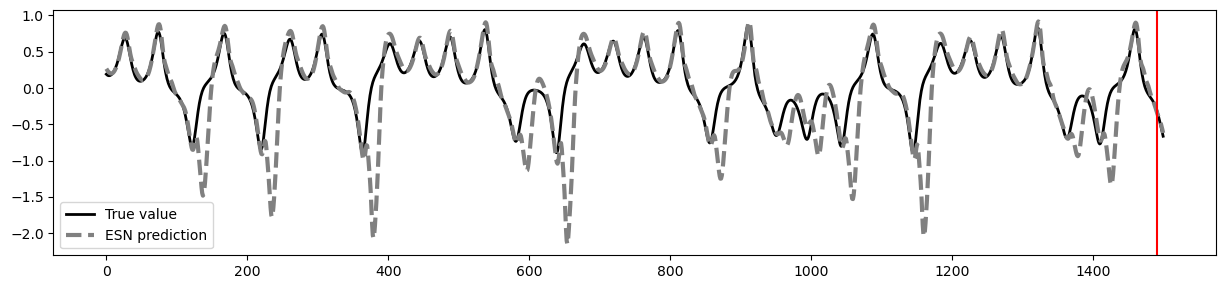

In [11]:
Preds = []
for i in range(N):
    x, y = to_forecasting(Y[i], forecast=10)

    X_train1, y_train1 = x[:train_train], y[:train_train]
    X_test1, y_test1 = x[train_train:], y[train_train:]

    #делаем предсказание
    Preds.append(esn.run(X_test1))
    results(Preds[i], y_test1, sample=1500)
    ###HERE1

In [14]:
Wout = readout.give_Wout()

In [15]:
Wout 

array([[ -682.63498563],
       [ -229.23660252],
       [ -284.65165695],
       [ -586.15361959],
       [  489.16960751],
       [-1569.41346518],
       [  547.58798054],
       [ -303.23531727],
       [  685.842332  ],
       [  112.07049031],
       [  286.52417661],
       [  462.60150124],
       [ -126.24265007],
       [  446.7641392 ],
       [  140.65711502],
       [  395.00092739],
       [ -240.22284152],
       [  127.18061649],
       [  226.94754439],
       [   60.35697738],
       [  196.77733818],
       [ -336.97686322],
       [   64.1212898 ],
       [  496.43647179],
       [  555.47367463],
       [  506.10863631],
       [  -56.5063448 ],
       [   36.09499296],
       [ -196.38275916],
       [ -407.99096129],
       [  470.03199174],
       [  151.99106264],
       [  243.81166611],
       [  322.34225751],
       [ -141.27053764],
       [  473.15633204],
       [  476.36241246],
       [   69.28379293],
       [ 1144.5740209 ],
       [-1608.96046684],


In [ ]:
# Получим первое состояние резервуара по формуле (из моего предположения):
